In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import seaborn as sns

In [2]:
from tensorflow.keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [3]:
print('X_train.shape  :')
print('-'*18)
print(X_train.shape)
print('-'*18)

print('\nX_test.shape  :')
print('-'*18)
print(X_test.shape)
print('-'*18)

print('\nY_train.shape  :')
print('-'*18)
print(Y_train.shape)
print('-'*18)

print('\nY_test.shape  :')
print('-'*18)
print(Y_test.shape)
print('-'*18)

X_train.shape  :
------------------
(50000, 32, 32, 3)
------------------

X_test.shape  :
------------------
(10000, 32, 32, 3)
------------------

Y_train.shape  :
------------------
(50000, 1)
------------------

Y_test.shape  :
------------------
(10000, 1)
------------------


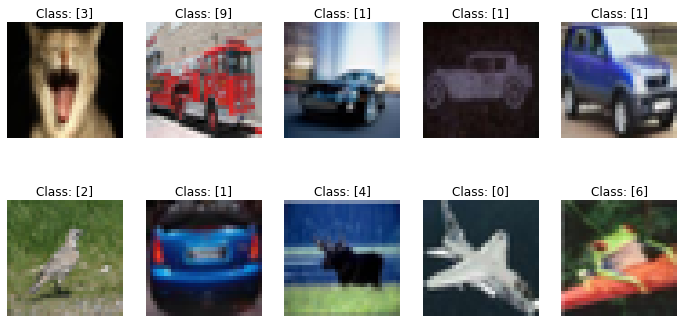

In [4]:
import random
indexes = random.sample(range(X_train.shape[0]), 10)
plt.figure(figsize=(12,6))
for i in range(1, len(indexes)+1):
    sp = plt.subplot(2, 5, i)
    sp.axis('Off')
    index = indexes[i-1]
    label = Y_train[index]
    plt.imshow(X_train[index])
    plt.title(f'Class: {label}')

In [5]:
X_train.dtype

dtype('uint8')

In [6]:
X_test.dtype

dtype('uint8')

In [7]:
X_train.max()

255

In [8]:
X_test.max()

255

In [9]:
X_train = X_train / 255
X_test = X_test / 255

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


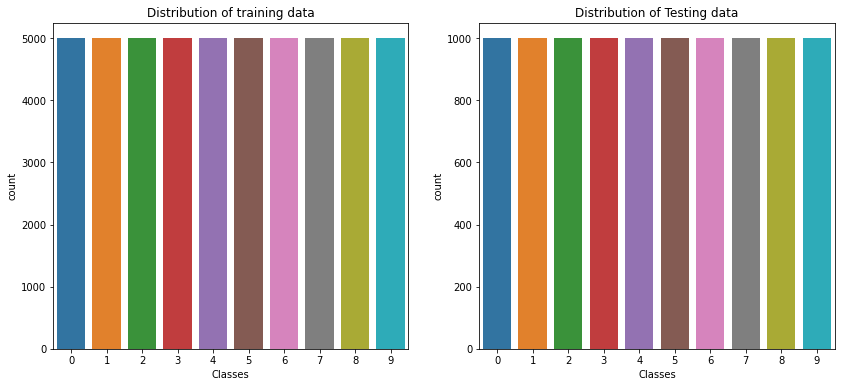

In [10]:
fig, axs = plt.subplots(1,2,figsize=(14,6))

# Count plot for training set
sns.countplot(Y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')

# Count plot for testing set
sns.countplot(Y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Classes')
plt.show()

In [11]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, 10)
# Y_test  = to_categorical(Y_test,  10)

In [12]:
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Lambda, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.utils import plot_model

In [13]:
data_gen = ImageDataGenerator(
                zoom_range = 0.1,
                validation_split=0.1,
                width_shift_range=0.1,
                height_shift_range=0.1,
                horizontal_flip=True,
            )

In [14]:
train_generator = data_gen.flow(X_train, Y_train,subset='training',batch_size=100)    

validation_generator = data_gen.flow(X_train, Y_train,subset='validation',batch_size=100) 

In [15]:
train_dim = next(train_generator)
print("Dimensions of a training sample",train_dim[0].shape)

# checking the new dimension of the validation data, which should include the batch size of 16 and new pixel size of 32 instead of 224 
val_dim = next(validation_generator)
print("Dimensions of a validation sample",val_dim[0].shape)

Dimensions of a training sample (100, 32, 32, 3)
Dimensions of a validation sample (100, 32, 32, 3)


In [16]:
lr_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, factor=0.5, min_lr=0.00001)

In [17]:
model = Sequential([
    Lambda(lambda x: (x-tf.math.reduce_mean(x))/tf.math.reduce_std(x), input_shape=(32, 32, 3)),
    Conv2D(32, (5,5), activation='relu', padding='valid'),
    BatchNormalization(),
    Conv2D(32, (4,4), activation='relu', padding='valid'),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPool2D(2, 2),
    
    Conv2D(32, (5,5), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (4,4), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(2, 2),
    
    Flatten(), 
    Dense(512, activation = "relu"),
    Dense(256, activation = "relu"),
    Dense(128, activation = "relu"),
    Dense(10, activation = "softmax") 
]) 

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

2023-01-03 19:11:07.448808: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        16416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 32)        1

In [19]:
history = model.fit(
            train_generator,
            epochs=20,
            validation_data=validation_generator,
            verbose=2,
            callbacks = lr_reduction
            )

2023-01-03 19:11:07.901421: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
450/450 - 101s - loss: 1.5575 - accuracy: 0.4251 - val_loss: 1.3345 - val_accuracy: 0.5222
Epoch 2/20
450/450 - 99s - loss: 1.1931 - accuracy: 0.5734 - val_loss: 1.1727 - val_accuracy: 0.5804
Epoch 3/20
450/450 - 99s - loss: 1.0272 - accuracy: 0.6346 - val_loss: 0.9827 - val_accuracy: 0.6558
Epoch 4/20
450/450 - 99s - loss: 0.9213 - accuracy: 0.6753 - val_loss: 0.9368 - val_accuracy: 0.6814
Epoch 5/20
450/450 - 99s - loss: 0.8552 - accuracy: 0.7008 - val_loss: 0.8323 - val_accuracy: 0.7080
Epoch 6/20
450/450 - 98s - loss: 0.8067 - accuracy: 0.7171 - val_loss: 0.8580 - val_accuracy: 0.7046
Epoch 7/20
450/450 - 97s - loss: 0.7619 - accuracy: 0.7338 - val_loss: 0.7994 - val_accuracy: 0.7262
Epoch 8/20
450/450 - 96s - loss: 0.7303 - accuracy: 0.7446 - val_loss: 0.7839 - val_accuracy: 0.7284
Epoch 9/20
450/450 - 99s - loss: 0.7019 - accuracy: 0.7552 - val_loss: 0.7290 - val_accuracy: 0.7508
Epoch 10/20
450/450 - 98s - loss: 0.6779 - accuracy: 0.7631 - val_loss: 0.7526 - val_accur

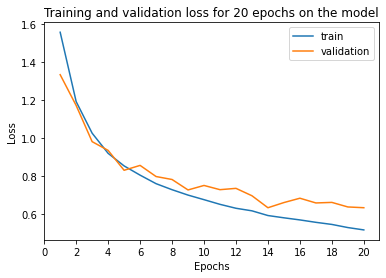

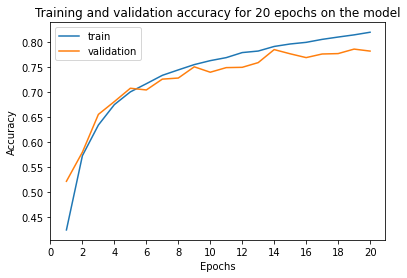

In [20]:
train_accuracy = history.history['accuracy']
validation_accuracy  = history.history['val_accuracy']
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs   = range(1, len(train_accuracy)+1) # Get number of epochs


# Plot training and validation loss per epoch
plt.plot(epochs, train_loss, label='train')
plt.plot(epochs, validation_loss, label='validation')
plt.title(f'Training and validation loss for {len(epochs)} epochs on the model')
plt.xticks([i for i in range(0, len(train_accuracy)+1, 2)])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()


# Plot training and validation accuracy per epoch
plt.plot(epochs, train_accuracy, label='train')
plt.plot(epochs, validation_accuracy, label='validation')
plt.title(f'Training and validation accuracy for {len(epochs)} epochs on the model')
plt.xticks([i for i in range(0, len(train_accuracy)+1, 2)])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

In [21]:
# model.save('model_adam.h5')

In [22]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
predictions = model.predict(X_test)
predictions = np.argmax(predictions,axis = 1)
predictions = [labels[i] for i in predictions]
predictions = pd.Series(predictions,name="Label")

In [23]:
submission = pd.concat([pd.Series(range(1,len(X_test)+1), name = "id"),predictions],axis = 1)
submission.head(10)

,id,Label
0,1,cat
1,2,ship
2,3,ship
3,4,airplane
4,5,frog
5,6,frog
6,7,automobile
7,8,frog
8,9,cat
9,10,automobile


In [24]:
submission

,id,Label
0,1,cat
1,2,ship
2,3,ship
3,4,airplane
4,5,frog
...,...,...
9995,9996,airplane
9996,9997,cat
9997,9998,dog
9998,9999,automobile


In [25]:
Y_test.flatten()

array([3, 8, 8, ..., 5, 1, 7], dtype=uint8)

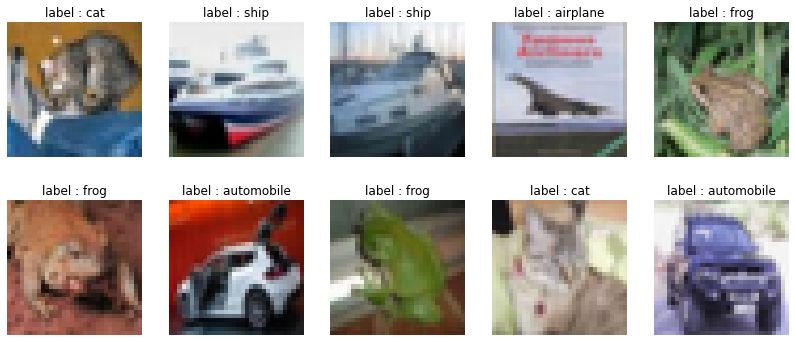

In [26]:
plt.figure(figsize=(14, 6))
for i in range(10):
    sp = plt.subplot(2, 5, i+1)
    sp.axis('Off')
    label = labels[Y_test.flatten()[i]]
    plt.imshow(X_test[i])
    plt.title(f"label : {label}")

In [27]:
submission.to_csv("submission.csv",index=False)